In [ ]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# ✅ Pfade zu deinen ROI-Bildern
base_path = "roi_dataset"  # z. B. roi_dataset/ok und roi_dataset/defect
ok_dir = os.path.join(base_path, "ok")
defect_dir = os.path.join(base_path, "defect")

# 📐 Zielgröße
IMG_SIZE = (64, 64)

In [44]:
import os
import cv2 as cv

src_dir = "/Users/saraheini/Documents/ADLS/4. Semester/ISP/ISP_Projekt/ISP_Projekt/dataset/defect"
target_dir = "roi_cropped_middle_defect"
os.makedirs(target_dir, exist_ok=True)

# 🔧 Zuschneideverhältnis (anpassen bei Bedarf)
# 🔧 Optimierte Zuschneideverhältnisse
x_start_ratio = 0.35  # vorher z. B. 0.15
x_end_ratio = 0.65   # vorher z. B. 0.85
y_start_ratio = 0.24   # war 0.45 → höher
y_end_ratio = 0.74     # war 0.65 → höher



for fname in os.listdir(src_dir):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    path = os.path.join(src_dir, fname)
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    if img is None:
        continue

    h, w = img.shape

    # 📐 Koordinaten berechnen
    x0 = int(w * x_start_ratio)
    x1 = int(w * x_end_ratio)
    y0 = int(h * y_start_ratio)
    y1 = int(h * y_end_ratio)

    roi = img[y0:y1, x0:x1]

    if roi.shape[0] > 0 and roi.shape[1] > 0:
        out_path = os.path.join(target_dir, f"roi_{fname}")
        cv.imwrite(out_path, roi)


In [45]:
# Für OK-Spritzen
src_dir_ok = "/Users/saraheini/Documents/ADLS/4. Semester/ISP/ISP_Projekt/ISP_Projekt/dataset/ok"
target_dir_ok = "roi_cropped_middle_ok"
os.makedirs(target_dir_ok, exist_ok=True)

for fname in os.listdir(src_dir_ok):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    path = os.path.join(src_dir_ok, fname)
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    if img is None:
        continue

    h, w = img.shape

    x0 = int(w * x_start_ratio)
    x1 = int(w * x_end_ratio)
    y0 = int(h * y_start_ratio)
    y1 = int(h * y_end_ratio)

    roi = img[y0:y1, x0:x1]

    if roi.shape[0] > 0 and roi.shape[1] > 0:
        out_path = os.path.join(target_dir_ok, f"roi_{fname}")
        cv.imwrite(out_path, roi)


In [50]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 🔧 Pfade
ok_dir = "roi_cropped_middle_ok"
defect_dir = "roi_cropped_middle_defect"
IMG_SIZE = (64, 64)

# 🔁 Bilder laden
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for fname in os.listdir(folder):
        if fname.endswith((".jpg", ".png", ".jpeg")):
            path = os.path.join(folder, fname)
            img = cv.imread(path, cv.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv.resize(img, IMG_SIZE)
                images.append(img_resized)
                labels.append(label)
    return images, labels

ok_imgs, ok_labels = load_images_from_folder(ok_dir, 0)
defect_imgs, defect_labels = load_images_from_folder(defect_dir, 1)

X = np.array(ok_imgs + defect_imgs)
# 🧮 Anzahl der Bilder pro Klasse anzeigen
print(f"Anzahl OK-Bilder:     {len(ok_imgs)}")
print(f"Anzahl Defect-Bilder: {len(defect_imgs)}")

y = np.array(ok_labels + defect_labels)

# 🔁 Normalisieren & vorbereiten
X = X / 255.0
X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
from sklearn.utils import class_weight

# Labels zurück in einfache Form (0 oder 1), nötig für Gewichtung
y_labels = y.copy()  # Noch in Integerform

# ⚖️ Gewichtung berechnen
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)
class_weight_dict = dict(enumerate(class_weights))
print("Klassen-Gewichte:", class_weight_dict)

y = to_categorical(y, num_classes=2)

# 🔀 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 🧠 Modell bauen
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 🏋️‍♂️ Training
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32,
    class_weight=class_weight_dict
)

# 📊 Auswertung
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2%}")


Anzahl OK-Bilder:     1437
Anzahl Defect-Bilder: 2823
Klassen-Gewichte: {0: np.float64(1.4822546972860124), 1: np.float64(0.7545164718384697)}


/Users/saraheini/Documents/ADLS/4. Semester/ISP/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,834 (6.20 MB)

 Trainable params: 1,624,834 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6544 - loss: 0.6275 - val_accuracy: 0.9073 - val_loss: 0.2911
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9041 - loss: 0.2791 - val_accuracy: 0.9237 - val_loss: 0.1989
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9350 - loss: 0.1874 - val_accuracy: 0.9601 - val_loss: 0.1293
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9550 - loss: 0.1214 - val_accuracy: 0.9812 - val_loss: 0.0694
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9726 - loss: 0.0815 - val_accuracy: 0.9812 - val_loss: 0.0559
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9805 - loss: 0.0526 - val_accuracy: 0.9695 - val_loss: 0.1018
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9811 - loss: 0.0567 - val_accuracy: 0.9800 - val_loss: 0.0628
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9866 - loss: 0.0412 - val_accu

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


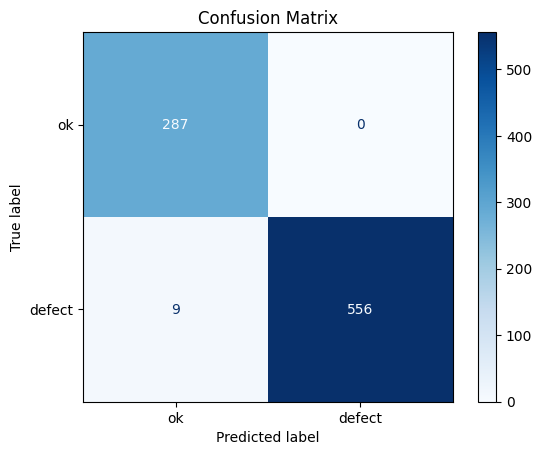


Klassifikationsbericht:
              precision    recall  f1-score   support

          ok       0.97      1.00      0.98       287
      defect       1.00      0.98      0.99       565

    accuracy                           0.99       852
   macro avg       0.98      0.99      0.99       852
weighted avg       0.99      0.99      0.99       852



In [51]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Rückkonvertieren von One-Hot zu Label
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion Matrix anzeigen
cm = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ok", "defect"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Klassifikationsbericht mit Precision, Recall, F1
print("\nKlassifikationsbericht:")
print(classification_report(y_test_true, y_test_pred, target_names=["ok", "defect"]))


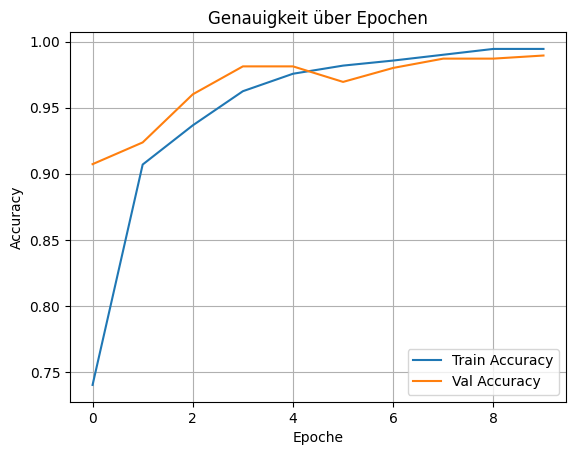

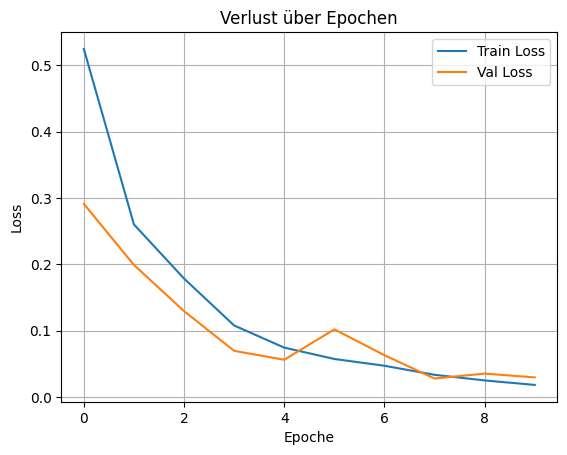

In [52]:
# Trainings- und Validierungsgenauigkeit plotten
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Genauigkeit über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Trainings- und Validierungsverlust plotten
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Verlust über Epochen')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_test_true, y_test_pred))
print("Recall:   ", recall_score(y_test_true, y_test_pred))


Precision: 1.0
Recall:    0.984070796460177


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


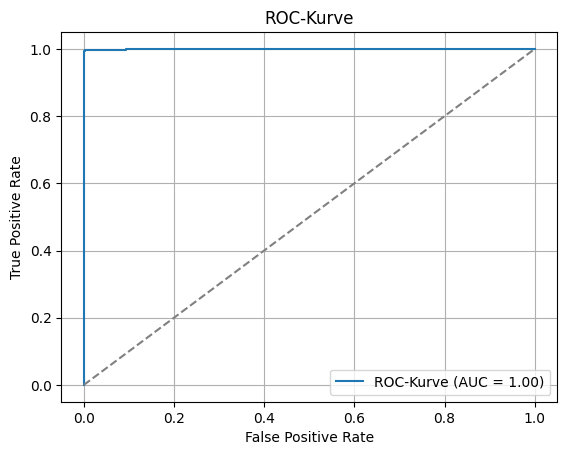

In [54]:
from sklearn.metrics import roc_curve, auc

# Wahrscheinlichkeiten für positive Klasse ("defect")
y_scores = model.predict(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC-Kurve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


/var/folders/8f/gjzdl2kx0m90vvxqxmgcf_zm0000gn/T/ipykernel_14825/2907860988.py:15: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/saraheini/Documents/ADLS/4. Semester/ISP/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


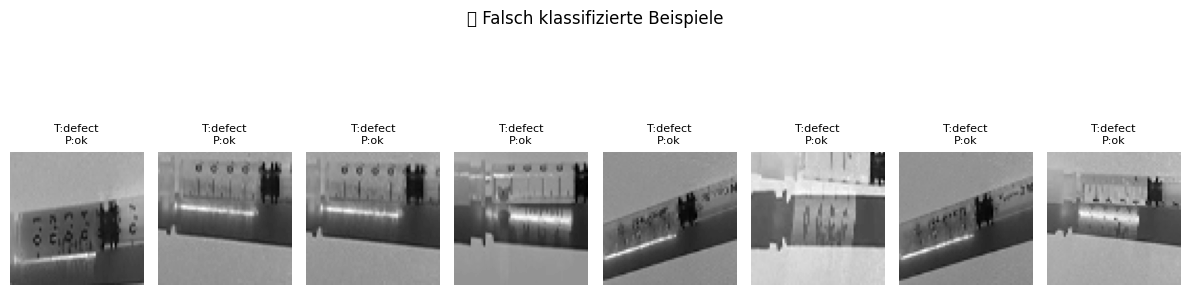

/var/folders/8f/gjzdl2kx0m90vvxqxmgcf_zm0000gn/T/ipykernel_14825/2907860988.py:15: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/saraheini/Documents/ADLS/4. Semester/ISP/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


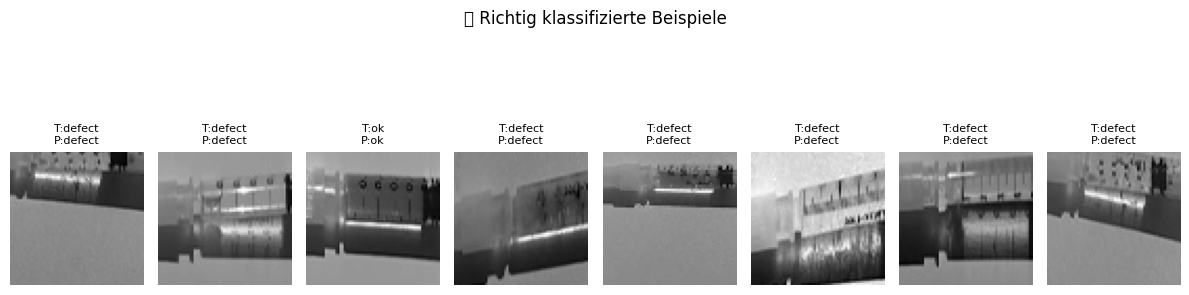

In [55]:
# ⏹️ Originalbilder ohne One-Hot
incorrect_idxs = np.where(y_test_true != y_test_pred)[0]
correct_idxs = np.where(y_test_true == y_test_pred)[0]

def show_examples(indices, title, max_images=8):
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(indices[:max_images]):
        plt.subplot(1, max_images, i + 1)
        plt.imshow(X_test[idx].squeeze(), cmap="gray")
        true = "ok" if y_test_true[idx] == 0 else "defect"
        pred = "ok" if y_test_pred[idx] == 0 else "defect"
        plt.title(f"T:{true}\nP:{pred}", fontsize=8)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Zeige falsche
show_examples(incorrect_idxs, "❌ Falsch klassifizierte Beispiele")

# Zeige richtige
show_examples(correct_idxs, "✅ Richtig klassifizierte Beispiele")
